In [27]:
from proservices.resources.database import Mysql
import pandas as pd
import numpy as np
import uuid
import math
from datetime import date
from typing import List, Any, Tuple
env = 'eulocal'
aid = '81B82121-29E3-4B23-B3B0AD6A2CCB2F50'
MIN_UUID = uuid.UUID('00000000-0000-0000-0000000000000000')
MAX_UUID = uuid.UUID('ffffffff-ffff-ffff-ffffffffffffffff')
pagesize = 10000

In [143]:
bounds = Mysql(env).hook().get_pandas_df(f"SELECT MIN(id) AS 'min', MAX(id) AS 'max' FROM media WHERE accountid = '{aid}'")

In [154]:
%%time
min_id = bounds.iloc[0]['min']
max_id = bounds.iloc[0]['max']
min_uuid_int = uuid.UUID(min_id).int
max_uuid_int = uuid.UUID(max_id).int
bins = np.linspace(min_uuid_int, max_uuid_int, num=10)
bins = [uuid.UUID(int=int(x)) for x in bins]
intervals = list(zip(bins[:-1], bins[1:]))
intervals.insert(0, (MIN_UUID, bins[0]))
intervals.append((bins[-1], MAX_UUID))
intervals

CPU times: user 1.59 ms, sys: 3.55 ms, total: 5.14 ms
Wall time: 5.09 ms


[(UUID('00000000-0000-0000-0000-000000000000'),
  UUID('0000050e-8067-4442-8a00-000000000000')),
 (UUID('0000050e-8067-4442-8a00-000000000000'),
  UUID('1c71c648-0190-0a00-0000-000000000000')),
 (UUID('1c71c648-0190-0a00-0000-000000000000'),
  UUID('38e38781-82b8-d000-0000-000000000000')),
 (UUID('38e38781-82b8-d000-0000-000000000000'),
  UUID('555548bb-03e1-9400-0000-000000000000')),
 (UUID('555548bb-03e1-9400-0000-000000000000'),
  UUID('71c709f4-850a-5c00-0000-000000000000')),
 (UUID('71c709f4-850a-5c00-0000-000000000000'),
  UUID('8e38cb2e-0633-2800-0000-000000000000')),
 (UUID('8e38cb2e-0633-2800-0000-000000000000'),
  UUID('aaaa8c67-875b-e800-0000-000000000000')),
 (UUID('aaaa8c67-875b-e800-0000-000000000000'),
  UUID('c71c4da1-0884-b000-0000-000000000000')),
 (UUID('c71c4da1-0884-b000-0000-000000000000'),
  UUID('e38e0eda-89ad-7800-0000-000000000000')),
 (UUID('e38e0eda-89ad-7800-0000-000000000000'),
  UUID('ffffd014-0ad6-4000-0000-000000000000')),
 (UUID('ffffd014-0ad6-4000-000

In [156]:
%%time

def generate_query(it):
    return """
    SELECT id, name, dateCreated
    FROM media
    WHERE accountid = '{accountid}'
    AND id >= '{lower}' AND id < '{higher}'
    """.format(accountid=aid, lower=it[0], higher=it[1])

def generate_queries(its):
    return {i:generate_query(it) for i,it in enumerate(its)}


def run_queries(queries, conn):
    ret = {}
    for i, q in queries.items():
        print('reading %d' % i)
        ret[i] = pd.read_sql(q, conn)
    return ret

res = run_queries(generate_queries(intervals), conn)
#conn.close()

reading 0
reading 1
reading 2
reading 3
reading 4
reading 5
reading 6
reading 7
reading 8
reading 9
reading 10
CPU times: user 21.9 s, sys: 6.94 s, total: 28.8 s
Wall time: 27.4 s


In [18]:
%%time
df = pd.read_sql(f"SELECT id FROM media WHERE accountid = '{aid}'", conn)
df.head()

CPU times: user 9.52 s, sys: 3.01 s, total: 12.5 s
Wall time: 11.6 s


,id
0,0000050E-8067-4442-89FE216BD22220A2
1,00001370-05A2-489A-8B41594749284DD3
2,00001A52-D355-41E5-B4C1744BFFD1C7D0
3,00003408-2F58-4C62-BC98A0FFF5720F4D
4,0000B56A-F06B-4A3A-92845A2284CE8C5B


In [41]:
df['int'] = df['id'].apply(lambda x: uuid.UUID(x).int)

In [88]:
import numpy as np
from scipy.stats import binned_statistic
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks", color_codes=True)

In [89]:
binned_statistic(df['float'], df['float'], bins=10, range=(min(df['float']), max(df['float'])))

BinnedStatisticResult(statistic=array([1.70378638e+37, 5.10675920e+37, 8.51034113e+37, 1.19117716e+38,
       1.53165307e+38, 1.87185975e+38, 2.21113134e+38, 2.55204579e+38,
       2.89242203e+38, 3.23336579e+38]), bin_edges=array([1.02560981e+32, 3.40282318e+37, 6.80563610e+37, 1.02084490e+38,
       1.36112620e+38, 1.70140749e+38, 2.04168878e+38, 2.38197007e+38,
       2.72225136e+38, 3.06253266e+38, 3.40281395e+38]), binnumber=array([1, 1, 1, ..., 7, 8, 8]))

In [100]:
data = np.random.random(100)
bins = np.linspace(0, 1, 10)
digitized = np.digitize(data, bins)
bin_means = [data[digitized == i].mean() for i in range(1, len(bins))]

<AxesSubplot:ylabel='Density'>

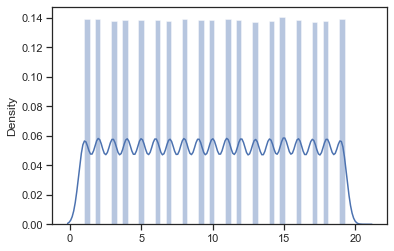

In [117]:
bins = np.linspace(df['float'].min(), df['float'].max(), 20)
inds = np.digitize(df['float'], bins)
sns.distplot(inds)

In [106]:
for n in range(10):#range(df['float'].size):
    print(bins[inds[n]-1], "<=", df['float'][n], "<", bins[inds[n]])

1.0256098121642296e+32 <= 1.0256098121642296e+32 < 3.4372873326197354e+36
1.0256098121642296e+32 <= 3.942410802848724e+32 < 3.4372873326197354e+36
1.0256098121642296e+32 <= 5.3390476342807125e+32 < 3.4372873326197354e+36
1.0256098121642296e+32 <= 1.0553337772316559e+33 < 3.4372873326197354e+36
1.0256098121642296e+32 <= 3.6795887295954196e+33 < 3.4372873326197354e+36
1.0256098121642296e+32 <= 4.322467149253519e+33 < 3.4372873326197354e+36
1.0256098121642296e+32 <= 4.383838099231311e+33 < 3.4372873326197354e+36
1.0256098121642296e+32 <= 5.422572930499637e+33 < 3.4372873326197354e+36
1.0256098121642296e+32 <= 6.68340329231854e+33 < 3.4372873326197354e+36
1.0256098121642296e+32 <= 7.036565462179693e+33 < 3.4372873326197354e+36


In [114]:
mediaids['int'] = mediaids['id'].apply(lambda x: uuid.UUID(x).int)
mediaids['float'] = mediaids['int'].apply(float)

<AxesSubplot:ylabel='Density'>

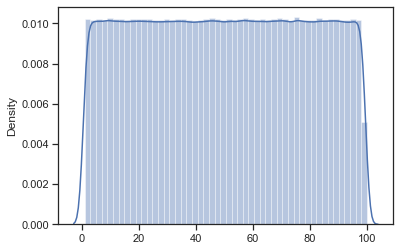

In [115]:
bins = np.linspace(mediaids['float'].min(), mediaids['float'].max(), 100)
inds = np.digitize(mediaids['float'], bins)
sns.distplot(inds)

In [118]:
uuid.UUID(int=mediaids['int'].iloc[0])

UUID('00000065-2240-47ab-ba73-fed08eac4de3')

In [119]:
mediaids['float'].value_counts()

2.124056e+38    1
1.794760e+38    1
1.459210e+38    1
3.198498e+38    1
1.543212e+38    1
               ..
1.958692e+38    1
6.965615e+37    1
1.997560e+38    1
6.264127e+37    1
6.747614e+37    1
Name: float, Length: 5397427, dtype: int64

### Paritions based on first page / LIMIT

In [17]:
env = 'eulocal'
aid = '81B82121-29E3-4B23-B3B0AD6A2CCB2F50'
MIN_UUID = uuid.UUID('00000000-0000-0000-0000000000000000')
MAX_UUID = uuid.UUID('ffffffff-ffff-ffff-ffffffffffffffff')
pagesize = 10000
bounds = Mysql(env).hook().get_pandas_df(f"SELECT MIN(id) AS 'min', MAX(id) AS 'max' FROM media WHERE accountid = '{aid}'")
kmin = bounds.iloc[0]['min']
kmax = bounds.iloc[0]['max']
first_page = Mysql(env).hook().get_pandas_df(f"SELECT id AS 'page_max' FROM media WHERE accountid = '{aid}' ORDER BY id ASC LIMIT {pagesize}")
pmax = first_page.iloc[-1]['page_max']
print("""
kmin: %s
kmax: %s
pmax: %s
""" % (kmin, kmax, pmax))


kmin: 000060C2-DEB2-4422-965893DE693A4641
kmax: FFFEADB8-CCBC-4705-BF9918F89B682B11
pmax: 270BD9E1-8CB9-4ECF-A29F04FC5950B024



In [24]:
kmin_int = uuid.UUID(kmin).int
kmax_int = uuid.UUID(kmax).int
pmax_int = uuid.UUID(pmax).int
partition_size_estimate = pmax_int - kmin_int
space_size = kmax_int - kmin_int
num_partitions = int(space_size / partition_size_estimate)
num_partitions

6

In [28]:
def get_partition_bounds(
    num_partitions: int,
    min_value: Any,
    max_value: Any,
    type_min_limit: Any = None,
    type_max_limit: Any = None,
) -> List[Tuple[Any, Any]]:
    bins = np.linspace(min_value, max_value, num=num_partitions + 1)
    intervals = list(zip(bins[:-1], bins[1:]))
    # make sure we don't miss elements on limits
    if type_min_limit is not None:
        intervals[0] = (type_min_limit, intervals[0][1])
    if type_max_limit is not None:
        intervals[-1] = (intervals[-1][0], type_max_limit)
    return intervals

def get_partition_bounds_uuid(
    num_partitions: int, min_value: str, max_value: str
) -> List[Tuple[Any, Any]]:
    min_v = uuid.UUID(min_value).int
    max_v = uuid.UUID(max_value).int
    intervals = get_partition_bounds(
        num_partitions,
        min_v,
        max_v,
        uuid.UUID("00000000-0000-0000-0000000000000000").int,
        uuid.UUID("ffffffff-ffff-ffff-ffffffffffffffff").int,
    )
    intervals = [
        (uuid.UUID(int=int(v[0])), uuid.UUID(int=int(v[1]))) for v in intervals
    ]
    return intervals

bounds = get_partition_bounds_uuid(num_partitions, kmin, kmax)
bounds

[(UUID('00000000-0000-0000-0000-000000000000'),
  UUID('2aaac2eb-dbb3-ee00-0000-000000000000')),
 (UUID('2aaac2eb-dbb3-ee00-0000-000000000000'),
  UUID('55552514-d8b5-9800-0000-000000000000')),
 (UUID('55552514-d8b5-9800-0000-000000000000'),
  UUID('7fff873d-d5b7-4400-0000-000000000000')),
 (UUID('7fff873d-d5b7-4400-0000-000000000000'),
  UUID('aaa9e966-d2b8-f000-0000-000000000000')),
 (UUID('aaa9e966-d2b8-f000-0000-000000000000'),
  UUID('d5544b8f-cfba-9800-0000-000000000000')),
 (UUID('d5544b8f-cfba-9800-0000-000000000000'),
  UUID('ffffffff-ffff-ffff-ffff-ffffffffffff'))]

In [30]:
parts = []
for i, b in enumerate(bounds):
    print('fetching part %d' % i)
    lb = b[0]
    ub = b[1]
    parts.append(Mysql(env).hook().get_pandas_df(f"SELECT id FROM media WHERE accountid = '{aid}' AND id >= '{lb}' AND id < '{ub}'"))

fetching part 0
fetching part 1
fetching part 2
fetching part 3
fetching part 4
fetching part 5


In [31]:
for i, p in enumerate(parts):
    print('part: %d len: %d' % (i, len(p)))

part: 0 len: 10957
part: 1 len: 10820
part: 2 len: 10746
part: 3 len: 10930
part: 4 len: 10787
part: 5 len: 10797


# Queries


SELECT mi.id, mi.mediaid, mi.originalFilename
FROM mediaitems mi
WHERE mi.id > '0008C7A6-1D08-4B04-AE9C35D5C18015AF'
ORDER BY mi.id ASC
LIMIT 10000;

SET @aid = '01AB8F36-582D-4319-AD98F0B687E3512F';

SET profiling = 1;

SELECT id, name, dateCreated
    FROM media
    WHERE accountid = '01AB8F36-582D-4319-AD98F0B687E3512F';
    
SHOW PROFILES;

SHOW PROCESSLIST;


SHOW VARIABLES LIKE '%timeout%';


SELECT *
FROM media
WHERE id < '0000050e-8067-4442-8a00-000000000000'
AND id >= '00000000-0000-0000-0000-000000000000'
AND accountid = '01AB8F36-582D-4319-AD98F0B687E3512F'
LIMIT 100;

SELECT MIN(id) AS 'min', MAX(id) AS 'max' FROM media WHERE accountid = @aid;

SELECT COUNT(1) FROM media WHERE accountid = @aid;


SELECT MIN(id), MAX(id)
FROM mediaitems;

SELECT COUNT(*) FROM mediaitems;

SHOW table status;

SELECT *
FROM mediaitems
WHERE id > ''
LIMIT 10;